# Image/Neural Style Transfer

<a name='1'></a>
## Packages

In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

<a name='3'></a>
## Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 
Specifically, I use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [3]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## Neural Style Transfer (NST)


- First, you will build the content cost function $J_{content}(C,G)$
- Second, you will build the style cost function $J_{style}(S,G)$
- Finally, you'll put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. Exciting!

<a name='4-1'></a>
### Computing the Content Cost

<a name='ex-1'></a>
### Compute_content_cost

In [4]:
def compute_content_cost(content_output, generated_output):
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_C, shape=[m, -1 , n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) # Or tf.reshape(a_G, shape=[m, -1 , n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

<a name='4-2'></a>
### Computing the Style Cost

<a name='4-2-1'></a>
#### Style Matrix

* The style matrix is also called a "Gram matrix." 


<a name='ex-2'></a>
### Gram_matrix

In [5]:
def gram_matrix(A):
    
    GA = tf.matmul(A, tf.transpose(A))

    return GA

<a name='4-2-2'></a>
#### Style Cost

<a name='ex-3'></a>
### Compute_layer_style_cost

In [6]:
def compute_layer_style_cost(a_S, a_G):
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    # OR a_S = tf.transpose(tf.reshape(a_S, shape=[ n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    return J_style_layer

<a name='4-2-3'></a>
#### Style Weights

In [7]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [8]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [9]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

<a name='ex-4'></a>
### Compute_style_cost

In [10]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    #Computes the overall style cost from several chosen layers
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

<a name='4-3'></a>
### Defining the Total Cost to Optimize

In [11]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

<a name='5'></a>
## Solving the Optimization Problem

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

<a id='part(4)'></a>

<a name='5-1'></a>
### Load the Content Image

(1, 400, 400, 3)


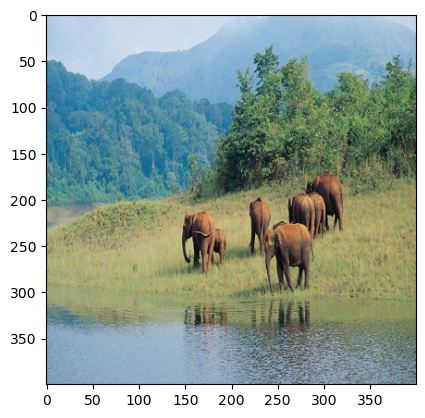

In [12]:
content_image = np.array(Image.open("images/Reserve.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### Load the Style Image

(1, 400, 400, 3)


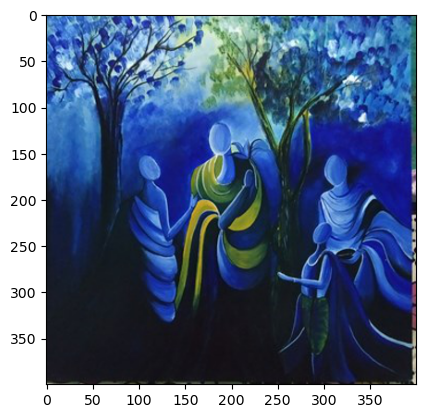

In [13]:
style_image =  np.array(Image.open("images/23495.jpeg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### Randomly Initialize the Image to be Generated

(1, 400, 400, 3)


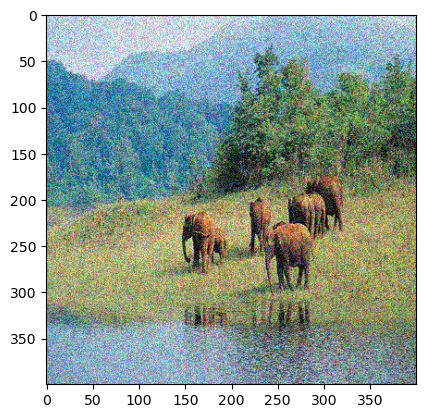

In [14]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## Load Pre-trained VGG19 Model

In [15]:
def get_layer_outputs(vgg, layer_names):
    #Creates a vgg model that returns a list of intermediate output values.
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [16]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [17]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

<a name='5-5'></a>
### Compute Total Cost

<a name='5-5-1'></a>
#### Compute the Content image Encoding (a_C)

In [18]:
# Assign the content image to be the input of the VGG model.  
# a_C is set to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
####  Compute the Style image Encoding (a_S) 


In [19]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [20]:
def clip_0_1(image):
    #Truncate all the pixels in the tensor to be between 0 and 1
    
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    #Converts the given tensor into a PIL image
    
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='ex-6'></a>
### Train_step 


In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        #(1 line)
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        #(1 line)
        J_style = compute_style_cost(a_S, a_G)

        #(2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J

<a name='5-6'></a>
### Train the Model

Epoch 0 


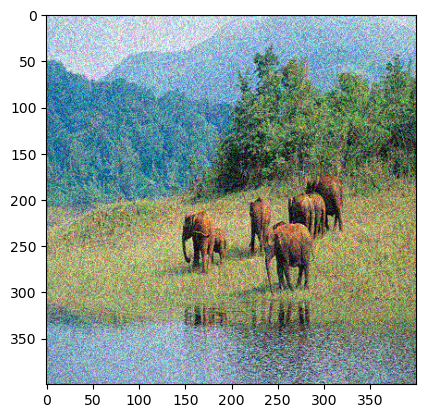

Epoch 250 


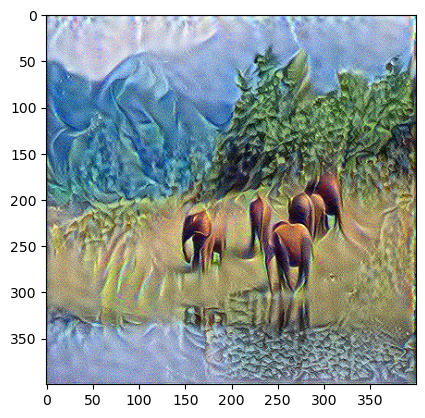

Epoch 500 


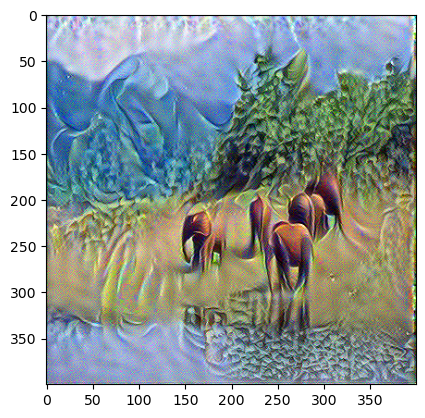

Epoch 750 


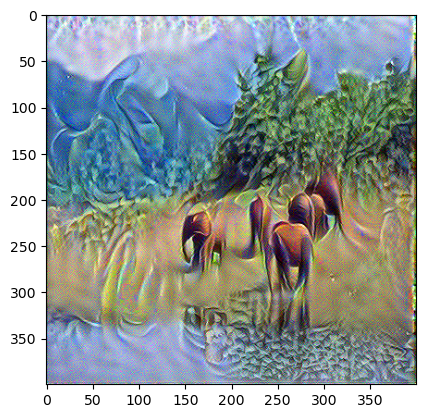

Epoch 1000 


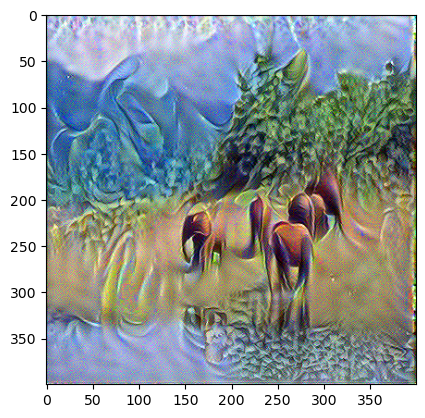

Epoch 1250 


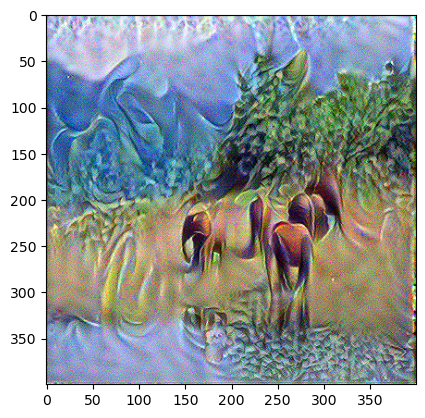

Epoch 1500 


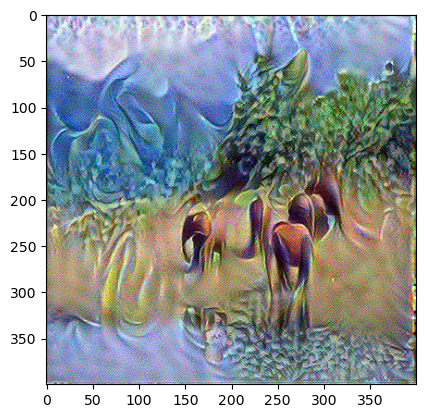

Epoch 1750 


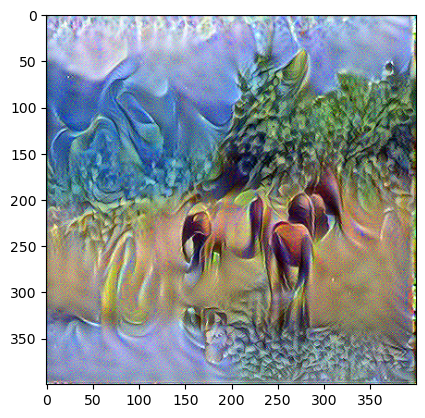

Epoch 2000 


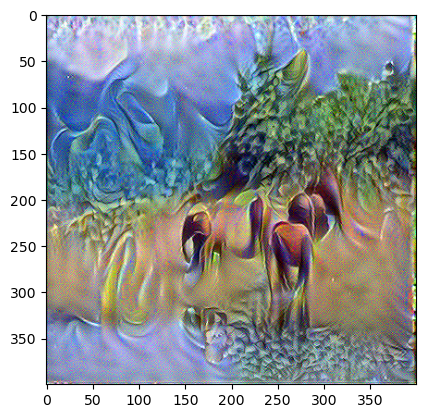

Epoch 2250 


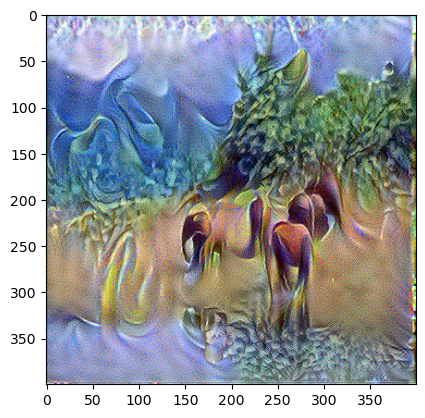

Epoch 2500 


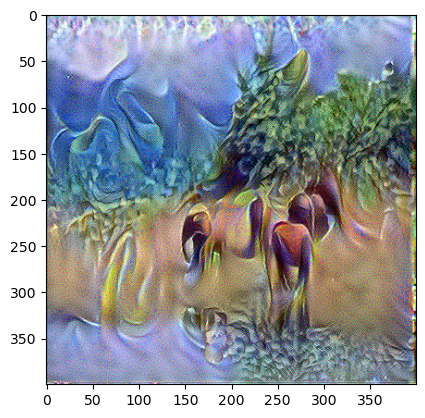

In [22]:
# Show the generated image at some epochs
generated_image = tf.Variable(generated_image)
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

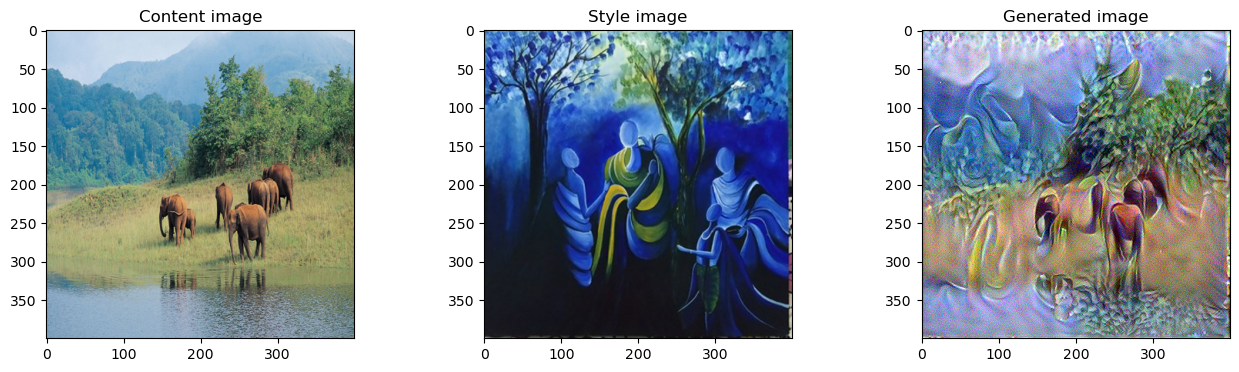

In [23]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()